In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
from time import time
from tensorflow.keras import optimizers, callbacks
from timeit import default_timer as timer
 
import pickle
from sklearn.model_selection import train_test_split
import sys
 
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
 
from tensorflow.keras.regularizers import l2
 
import tensorflow as tf
 
filtered = True
 
if filtered:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133_filtered.npy"
    #dataset_path = "cullpdb+profile_6133_filtered.npy"
else:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133.npy"
    #dataset_path = "cullpdb+profile_6133.npy"
 
cb513_path = "/content/drive/My Drive/cb513+profile_split1.npy"
#cb513_path = "cb513+profile_split1.npy"
 
sequence_len = 700
total_features = 57
amino_acid_residues = 21
num_classes = 8
cnn_width = 17
 #"/content/drive/My Drive/cullpdb+profile_6133.npy"
def get_dataset(path="/content/drive/My Drive/cullpdb+profile_6133.npy"):
    ds = np.load(path)
    ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
    ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
    ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
    ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes]
    return ret
 
def get_data_labels(D):
    X = D[:, :, 0:amino_acid_residues]
    Y = D[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y
 
def resphape_labels(labels):
    Y = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))
    Y = Y[~np.all(Y == 0, axis=1)]
    return Y
 
def reshape_data(X):
    padding = np.zeros((X.shape[0], X.shape[2], int(cnn_width/2)))
    X = np.dstack((padding, np.swapaxes(X, 1, 2), padding))
    X = np.swapaxes(X, 1, 2)
    res = np.zeros((X.shape[0], X.shape[1] - cnn_width + 1, cnn_width, amino_acid_residues))
    for i in range(X.shape[1] - cnn_width + 1):
        res[:, i, :, :] = X[:, i:i+cnn_width, :]
    res = np.reshape(res, (X.shape[0]*(X.shape[1] - cnn_width + 1), cnn_width, amino_acid_residues))
    res = res[np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues), :, :]
    return res
 
def get_dataset_reshaped(seed=None):
    D = get_dataset(dataset_path)
    Train, Test, Validation = split_dataset(D, seed)
    X_te, Y_te = get_data_labels(Test)
    X_tr, Y_tr = get_data_labels(Train)
    X_v, Y_v = get_data_labels(Validation)
 
    X_train = reshape_data(X_tr)
    X_test = reshape_data(X_te)
    X_validation = reshape_data(X_v)
 
    Y_train = resphape_labels(Y_tr)
    Y_test = resphape_labels(Y_te)
    Y_validation = resphape_labels(Y_v)
 
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
 
def split_dataset(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0]*0.8)
    test_val_split = int(Dataset.shape[0]*0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split+test_val_split, :, :]
    Validation = Dataset[train_split+test_val_split:, :, :]
    return Train, Test, Validation
 
def split_like_paper(Dataset, seed=None):
   
    if seed is not None:
        np.random.seed(seed)
        np.random.shuffle(Dataset)
    Train = Dataset[0:5600, :, :]
    Test = Dataset[5600:5877, :, :]
    Validation = Dataset[5877:, :, :]
    return Train, Test, Validation
 
def get_resphaped_dataset_paper():
    D = get_dataset()
    Train, Test, Validation = split_like_paper(D)
    X_te, Y_te = get_data_labels(Test)
    X_tr, Y_tr = get_data_labels(Train)
    X_v, Y_v = get_data_labels(Validation)
 
    X_train = reshape_data(X_tr)
    X_test = reshape_data(X_te)
    X_validation = reshape_data(X_v)
 
    Y_train = resphape_labels(Y_tr)
    Y_test = resphape_labels(Y_te)
    Y_validation = resphape_labels(Y_v)
 
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
 
def get_cb513():
    CB = get_dataset(cb513_path)
    X, Y = get_data_labels(CB)
    return reshape_data(X), resphape_labels(Y)
 
do_log = True
stop_early = False
show_plots = True
 
start_time = timer()
 
print("Collecting Dataset...")
 
if filtered:
    # Split the dataset in 0.8 train, 0.1 test, 0.1 validation with shuffle (optionally seed)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = get_dataset_reshaped(seed=100)
else:
    # Slit the dataset with the same indexes used in the paper (Only for CullPDB6133 not filtered)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = get_resphaped_dataset_paper()
 
end_time = timer()
print("\n\nTime elapsed getting Dataset: " + "{0:.2f}".format((end_time - start_time)) + " s")
 
if filtered:
    print("Using CullPDB Filtered dataset")
 
 
LR = 0.0009 
drop_out = 0.38
batch_dim = 64
nn_epochs = 35
 
#loss = 'categorical_hinge'
loss = 'categorical_crossentropy' 
#loss = 'mean_absolute_error' 
#loss = 'mean_squared_logarithmic_error'
 

def CNN_model():
    m = Sequential()
    m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(cnn_width, amino_acid_residues)))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(128, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(64, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    # m.add(Conv1D(32, 3, padding='same', activation='relu'))
    # m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    # m.add(Dropout(drop_out))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(num_classes, activation = 'softmax'))
    opt = optimizers.Adam(lr=LR)
    m.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy', 'mae'])
    
    return m
 
 
 
net = CNN_model()
print(net.summary())
history = net.fit(X_train, Y_train, epochs=nn_epochs, batch_size=batch_dim, shuffle=True,
                        validation_data=(X_val, Y_val))
 
scores = net.evaluate(X_test, Y_test)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))



Time elapsed getting Dataset: 20.13 s
Using CullPDB Filtered dataset
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17, 128)           13568     
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 17, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 128)           0         
___________________________________________________

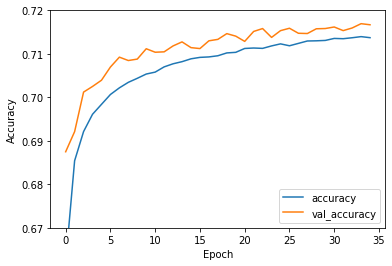

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.67, 0.72])
plt.legend(loc='lower right')

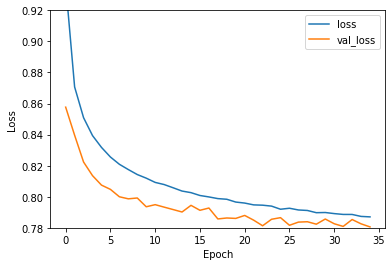

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.78, 0.92])
plt.legend(loc='upper right')

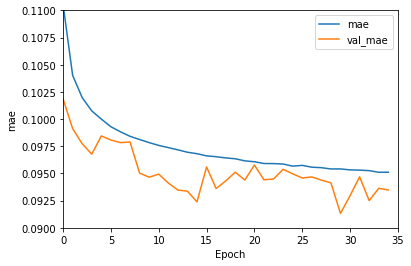

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.xlim([0,35])
plt.ylim([0.09, 0.11])
plt.legend(loc='upper right')

In [ ]:
net.predict(X_test[:4])

array([[1.0000000e+00, 0.0000000e+00, 1.8448757e-14, 0.0000000e+00,
        0.0000000e+00, 6.4583396e-14, 1.2736949e-12, 1.2854980e-19],
       [6.7667484e-01, 5.3119272e-02, 1.8703869e-01, 3.6125409e-03,
        0.0000000e+00, 6.8550088e-02, 1.9633130e-06, 1.1002660e-02],
       [4.2325869e-01, 9.7242352e-03, 4.5852503e-01, 1.6479718e-02,
        7.9492662e-10, 1.5315614e-02, 5.0149240e-02, 2.6547477e-02],
       [4.3714058e-01, 8.2430206e-03, 3.1589249e-01, 1.8137129e-02,
        2.3967366e-06, 1.2579091e-01, 5.5085428e-02, 3.9708037e-02]],
      dtype=float32)

In [ ]:
Y_test[:4]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])

In [ ]:
net.save("my_model.h5")

In [ ]:
import numpy as np

filtered = True
 
if filtered:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133_filtered.npy"
    #dataset_path = "cullpdb+profile_6133_filtered.npy"
else:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133.npy"
    #dataset_path = "cullpdb+profile_6133.npy"
 
cb513_path = "/content/drive/My Drive/cb513+profile_split1.npy"
#cb513_path = "cb513+profile_split1.npy"
 
sequence_len = 700
total_features = 57
amino_acid_residues = 21
num_classes = 8
cnn_width = 17
path="/content/drive/My Drive/cullpdb+profile_6133.npy"
ds = np.load(path)
print(ds.shape)
print(ds.shape[0])
print(ds.shape[1])
ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes]
D = ret
np.random.seed()
np.random.shuffle(D)
train_split = int(D.shape[0]*0.8)
test_val_split = int(D.shape[0]*0.1)
Train = D[0:train_split, :, :]
Test = D[train_split:train_split+test_val_split, :, :]
Validation = D[train_split+test_val_split:, :, :]
X_tr = Train[:, :, 0:amino_acid_residues]
Y_tr = Train[:, :, amino_acid_residues:amino_acid_residues + num_classes]
print(Y_tr)
X_te = Test[:, :, 0:amino_acid_residues]
Y_te = Test[:, :, amino_acid_residues:amino_acid_residues + num_classes]
X_v = Validation[:, :, 0:amino_acid_residues]
Y_v = Validation[:, :, amino_acid_residues:amino_acid_residues + num_classes]
print(X_tr.shape)
print(Y_tr.shape)
print(X_te.shape)
print(Y_te.shape)
print(X_v.shape)
print(Y_v.shape)


(6133, 39900)
6133
39900
[[[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 1. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [0. 0. 1. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  [1. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. .

In [ ]:
def reshape_data(X):
    padding = np.zeros((X.shape[0], X.shape[2], int(cnn_width/2)))
    print(padding.shape)
    X = np.dstack((padding, np.swapaxes(X, 1, 2), padding))
    print(X.shape)
    X = np.swapaxes(X, 1, 2)
    print(X.shape)
    res = np.zeros((X.shape[0], X.shape[1] - cnn_width + 1, cnn_width, amino_acid_residues))
    print(res.shape)
    for i in range(X.shape[1] - cnn_width + 1):
        res[:, i, :, :] = X[:, i:i+cnn_width, :]
    res = np.reshape(res, (X.shape[0]*(X.shape[1] - cnn_width + 1), cnn_width, amino_acid_residues))
    print("1st:",res.shape)
    print(sum(np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues)))
    res = res[np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues), :, :]
    print("2nd",res.shape)
    return res

In [ ]:
def resphape_labels(labels):
    Y = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))
   
    Y = Y[~np.all(Y == 0, axis=1)]
   
    return Y

In [ ]:
a = np.array((1,2,3))
b = np.array((2,3,4))
np.dstack((a,b))

array([[[1, 2],
        [2, 3],
        [3, 4]]])

In [ ]:
X_train = reshape_data(X_tr)
X_test = reshape_data(X_te)
X_validation = reshape_data(X_v)
print(X_train.shape)
print(X_test.shape)
print(X_validation.shape)

(4906, 21, 8)
(4906, 21, 716)
(4906, 716, 21)
(4906, 700, 17, 21)
1st: (3434200, 17, 21)
1021098
2nd (1021098, 17, 21)
(613, 21, 8)
(613, 21, 716)
(613, 716, 21)
(613, 700, 17, 21)
1st: (429100, 17, 21)
126774
2nd (126774, 17, 21)
(614, 21, 8)
(614, 21, 716)
(614, 716, 21)
(614, 700, 17, 21)
1st: (429800, 17, 21)
130462
2nd (130462, 17, 21)
(1021098, 17, 21)
(126774, 17, 21)
(130462, 17, 21)


In [ ]:

Y_train = resphape_labels(Y_tr)

Y_test = resphape_labels(Y_te)
Y_validation = resphape_labels(Y_v)
#print(Y_validation)

In [ ]:
Y = np.ones((2,8))
print(Y)

[[1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [ ]:
Y = Y[~np.all(Y == 0, axis=1)]

In [ ]:
print(Y)

[]


In [ ]:
np.all([[True,False],[True,True]], axis=1)

array([False,  True])

In [ ]:
x = [[1,2],[1,2]]
print(x)

[[1, 2], [1, 2]]


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, Dropout, Dense, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers, callbacks
import tensorflow as tf
LR = 0.0009 
drop_out = 0.38
batch_dim = 64
nn_epochs = 35
 
#loss = 'categorical_hinge'
loss = 'categorical_crossentropy' 
#loss = 'mean_absolute_error' 
#loss = 'mean_squared_logarithmic_error'
 

def CNN_model():
    m = Sequential()
    m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(cnn_width, amino_acid_residues)))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(128, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(64, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    # m.add(Conv1D(32, 3, padding='same', activation='relu'))
    # m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    # m.add(Dropout(drop_out))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(num_classes, activation = 'softmax'))
    opt = optimizers.Adam(lr=LR)
    m.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy', 'mae'])
    
    return m
 
 
 
net = CNN_model()
print(net.summary())
history = net.fit(X_train, Y_train, epochs=nn_epochs, batch_size=batch_dim, shuffle=True,
                        validation_data=(X_validation, Y_validation))
 
scores = net.evaluate(X_test, Y_test)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 17, 128)           13568     
_________________________________________________________________
batch_normalization_6 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_6 (Dropout)          (None, 17, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 17, 128)           49280     
_________________________________________________________________
batch_normalization_7 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_7 (Dropout)          (None, 17, 128)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 17, 64)           

In [ ]:
import numpy as np
from time import time
from tensorflow.keras import optimizers, callbacks
from timeit import default_timer as timer
 
import pickle
from sklearn.model_selection import train_test_split
import sys
 
 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv1D, AveragePooling1D, MaxPooling1D, TimeDistributed, LeakyReLU, BatchNormalization, Flatten
 
from tensorflow.keras.regularizers import l2
 
import tensorflow as tf
 
filtered = True
 
if filtered:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133_filtered.npy"
    #dataset_path = "cullpdb+profile_6133_filtered.npy"
else:
    dataset_path = "/content/drive/My Drive/cullpdb+profile_6133.npy"
    #dataset_path = "cullpdb+profile_6133.npy"
 

 
sequence_len = 700
total_features = 57
amino_acid_residues = 21
num_classes = 8
cnn_width = 17
 #"/content/drive/My Drive/cullpdb+profile_6133.npy"
def get_dataset(path):
    ds = np.load(path)
    ds = np.reshape(ds, (ds.shape[0], sequence_len, total_features))
    ret = np.zeros((ds.shape[0], ds.shape[1], amino_acid_residues + num_classes))
    ret[:, :, 0:amino_acid_residues] = ds[:, :, 35:56]
    ret[:, :, amino_acid_residues:] = ds[:, :, amino_acid_residues + 1:amino_acid_residues+ 1 + num_classes]
    return ret
 
def get_data_labels(D):
    X = D[:, :, 0:amino_acid_residues]
    Y = D[:, :, amino_acid_residues:amino_acid_residues + num_classes]
    return X, Y
 
def resphape_labels(labels):
    Y = np.reshape(labels, (labels.shape[0]*labels.shape[1], labels.shape[2]))
    Y = Y[~np.all(Y == 0, axis=1)]
    return Y
 
def reshape_data(X):
    padding = np.zeros((X.shape[0], X.shape[2], int(cnn_width/2)))
    X = np.dstack((padding, np.swapaxes(X, 1, 2), padding))
    X = np.swapaxes(X, 1, 2)
    res = np.zeros((X.shape[0], X.shape[1] - cnn_width + 1, cnn_width, amino_acid_residues))
    for i in range(X.shape[1] - cnn_width + 1):
        res[:, i, :, :] = X[:, i:i+cnn_width, :]
    res = np.reshape(res, (X.shape[0]*(X.shape[1] - cnn_width + 1), cnn_width, amino_acid_residues))
    res = res[np.count_nonzero(res, axis=(1,2))>(int(cnn_width/2)*amino_acid_residues), :, :]
    return res
 
def get_dataset_reshaped(seed=None):
    D = get_dataset(dataset_path)
    Train, Test, Validation = split_dataset(D, seed)
    X_te, Y_te = get_data_labels(Test)
    X_tr, Y_tr = get_data_labels(Train)
    X_v, Y_v = get_data_labels(Validation)
 
    X_train = reshape_data(X_tr)
    X_test = reshape_data(X_te)
    X_validation = reshape_data(X_v)
 
    Y_train = resphape_labels(Y_tr)
    Y_test = resphape_labels(Y_te)
    Y_validation = resphape_labels(Y_v)
 
    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
 
def split_dataset(Dataset, seed=None):
    np.random.seed(seed)
    np.random.shuffle(Dataset)
    train_split = int(Dataset.shape[0]*0.8)
    test_val_split = int(Dataset.shape[0]*0.1)
    Train = Dataset[0:train_split, :, :]
    Test = Dataset[train_split:train_split+test_val_split, :, :]
    Validation = Dataset[train_split+test_val_split:, :, :]
    return Train, Test, Validation
 

    return X_train, X_validation, X_test, Y_train, Y_validation, Y_test
 
do_log = True
stop_early = False
show_plots = True
 
start_time = timer()
 
print("Collecting Dataset...")
 
if filtered:
    # Split the dataset in 0.8 train, 0.1 test, 0.1 validation with shuffle (optionally seed)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = get_dataset_reshaped(seed=100)
else:
    # Slit the dataset with the same indexes used in the paper (Only for CullPDB6133 not filtered)
    X_train, X_val, X_test, Y_train, Y_val, Y_test = get_resphaped_dataset_paper()
 
end_time = timer()
print("\n\nTime elapsed getting Dataset: " + "{0:.2f}".format((end_time - start_time)) + " s")
 
if filtered:
    print("Using CullPDB Filtered dataset")
 
 
LR = 0.0009 
drop_out = 0.38
batch_dim = 64
nn_epochs = 35
 
#loss = 'categorical_hinge'
loss = 'categorical_crossentropy' 
#loss = 'mean_absolute_error' 
#loss = 'mean_squared_logarithmic_error'
 

def CNN_model():
    m = Sequential()
    m.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=(cnn_width, amino_acid_residues)))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(128, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    m.add(Conv1D(64, 3, padding='same', activation='relu'))
    m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    m.add(Dropout(drop_out))
    # m.add(Conv1D(32, 3, padding='same', activation='relu'))
    # m.add(BatchNormalization())
    # m.add(MaxPooling1D(pool_size=2))
    # m.add(Dropout(drop_out))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dense(32, activation='relu'))
    m.add(Dense(num_classes, activation = 'softmax'))
    opt = optimizers.Adam(lr=LR)
    m.compile(optimizer=opt,
              loss=loss,
              metrics=['accuracy', 'mae'])
    
    return m
 
 
 
net = CNN_model()
print(net.summary())
history = net.fit(X_train, Y_train, epochs=nn_epochs, batch_size=batch_dim, shuffle=True,
                        validation_data=(X_val, Y_val))
 
scores = net.evaluate(X_test, Y_test)
print("Loss: " + str(scores[0]) + ", Accuracy: " + str(scores[1]) + ", MAE: " + str(scores[2]))



Time elapsed getting Dataset: 15.80 s
Using CullPDB Filtered dataset
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 17, 128)           13568     
_________________________________________________________________
batch_normalization (BatchNo (None, 17, 128)           512       
_________________________________________________________________
dropout (Dropout)            (None, 17, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 128)           512       
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 128)           0         
___________________________________________________

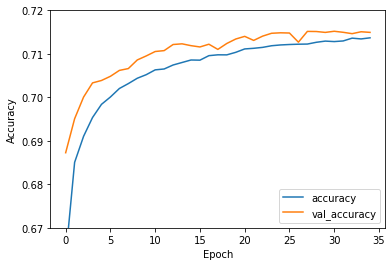

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.67, 0.72])
plt.legend(loc='lower right')

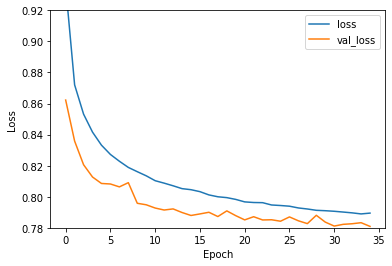

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.78, 0.92])
plt.legend(loc='upper right')

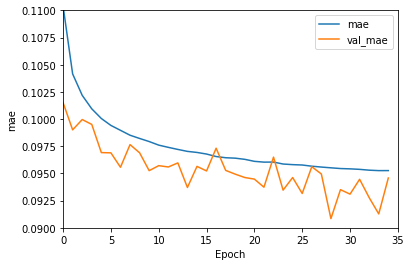

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['mae'], label='mae')
plt.plot(history.history['val_mae'], label = 'val_mae')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.xlim([0,35])
plt.ylim([0.09, 0.11])
plt.legend(loc='upper right')

In [ ]:
net.predict(X_test[:4])

array([[1.00000000e+00, 2.10360885e-26, 1.02977217e-10, 1.00875955e-28,
        0.00000000e+00, 1.23899331e-13, 5.51022509e-12, 1.24774365e-14],
       [8.43977571e-01, 2.38450840e-02, 5.26789501e-02, 9.79629252e-03,
        4.98238506e-10, 4.26482596e-02, 2.16519949e-03, 2.48885788e-02],
       [5.12808800e-01, 1.61827356e-02, 2.80735224e-01, 3.32096033e-02,
        5.74077285e-06, 6.08463772e-02, 5.63057251e-02, 3.99057195e-02],
       [3.40042204e-01, 1.25434482e-02, 4.46180284e-01, 2.96869297e-02,
        3.91242338e-06, 7.08803162e-02, 7.38863051e-02, 2.67765671e-02]],
      dtype=float32)

In [ ]:
Y_test[:4]

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0.]])